In [1]:
import numpy as np
import sqlite3
from typing import List
import re
import cv2
from collections import namedtuple
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
conn = sqlite3.connect("data.sqlite3")
cursor = conn.cursor()

In [3]:
def split_frame(frame : str):
    nums = re.findall(r'\d+', frame)
    return np.array(nums[::2]).astype(int), np.array(nums[1::2]).astype(int)

# Data Procurement
With the tension board, there are hundreds of thousands of user created problems. While this in theory gives us a lot of training data. The data quality can be sub par for a regression problem. To solve this, we want to look at TB2 "Classics" problems chosen by Tension that they feel are high quality and at that grade.

We accomplish this by looking for benchmark difficulty and layout_id = 10 (this coorelates to the TB2 mirror layout)
Additionally we double the benchmark data to account for additional non benchmark data we add later
```sql
SELECT 
climbs.setter_username, 
climbs.name, 
climbs.description, 
CASE
    WHEN LOWER(climbs.description) LIKE "%no%match%" THEN TRUE
    ELSE FALSE
END as matching,
climb_stats.angle, 
climb_stats.benchmark_difficulty, 
climbs.frames
FROM climbs
INNER JOIN climb_stats
on climb_stats.climb_uuid = climbs.uuid
WHERE climb_stats.benchmark_difficulty is not null --Gets Only Classics
AND climbs.layout_id = 10
```

In [4]:
query = '''
SELECT 
climbs.setter_username, 
climbs.name, 
climbs.description, 
CASE
    WHEN LOWER(climbs.description) LIKE "%no%match%" THEN FALSE
    ELSE TRUE
END as matching,
climb_stats.angle, 
climbs.frames,
climb_stats.benchmark_difficulty
FROM climbs
INNER JOIN climb_stats
on climb_stats.climb_uuid = climbs.uuid
WHERE climb_stats.benchmark_difficulty is not null --Gets Only Classics
AND climbs.layout_id = 10
'''

cursor.execute(query)
result = cursor.fetchall()
benchmark_df = pd.DataFrame(result, columns = ["Setter", "Name", "Description", "Matching", "Angle", "Frames", "Difficulty"])
benchmark_df = benchmark_df.astype({'Setter' : str, 'Name' : str, 'Description' : str, 'Matching' : int, 'Angle' : float, 'Frames' : str, 'Difficulty' : float})
print(benchmark_df.shape)



(640, 7)


## Non Benchmark climbs
Since we have a pretty small set of data for benchmarks I decided to increase the dataset to include non benchmarks, to maximize quality I only included ones with greater than 50 ascents and where the display difficulty was close to the difficulty average.


In [5]:
query = '''
SELECT 
climbs.setter_username, 
climbs.name, 
climbs.description, 
CASE
    WHEN LOWER(climbs.description) LIKE "%no%match%" THEN FALSE
    ELSE TRUE
END as matching,
climb_stats.angle, 
climbs.frames,
climb_stats.display_difficulty
FROM climbs
INNER JOIN climb_stats
on climb_stats.climb_uuid = climbs.uuid
WHERE climb_stats.benchmark_difficulty is  null --Gets non classics
AND climb_stats.ascensionist_count > 100
AND climbs.layout_id = 10
AND abs(display_difficulty - difficulty_average) < 0.5

'''
cursor.execute(query)
result = cursor.fetchall()
non_benchmark_df = pd.DataFrame(result, columns = ["Setter", "Name", "Description", "Matching", "Angle", "Frames", "Difficulty"])
non_benchmark_df = non_benchmark_df.astype({'Setter' : str, 'Name' : str, 'Description' : str, 'Matching' : int, 'Angle' : float, 'Frames' : str, 'Difficulty' : float})
df = pd.concat([benchmark_df, non_benchmark_df], ignore_index = True)
df = df.astype({'Setter' : str, 'Name' : str, 'Description' : str, 'Matching' : int, 'Angle' : float, 'Frames' : str, 'Difficulty' : float})
print(non_benchmark_df.shape)
print(df.shape)

(765, 7)
(1405, 7)


## Getting Additional Data
With only choosing classics, we only have around 640 samples. To help increase our sample size, we can use the fact that we are using the TB2 mirror layout. This means for every problem there is a mirror that has the same grade. So let's first create a mapping function to map the mirror holds.

We will use the below query to get the mappings, and also get some additional data for when we encode our data.

In [6]:
query = '''
SELECT
  p.id AS placement_id,
  mp.id AS mirror_placement_id,
  h.x,
  h.y,
  ROW_NUMBER() OVER (ORDER BY p.id) - 1 AS row_num
FROM placements p
JOIN holes h ON p.hole_id = h.id
LEFT JOIN holes mh ON mh.x = -h.x AND mh.y = h.y
LEFT JOIN placements mp ON mp.hole_id = mh.id AND mp.layout_id = 10
WHERE p.layout_id = 10
ORDER BY p.id;
'''

cursor.execute(query)
map_df = pd.DataFrame(cursor.fetchall(), columns = ["ID", "Mirror", "H", "W", "Row"])
mirror_map = dict(zip(map_df['ID'], map_df['Mirror']))
coords_map = dict(zip(map_df['ID'], list(list(t) for t in zip(map_df['H'], map_df['W']))))
encode_map = dict(zip(map_df['ID'], map_df['Row'])) 


## Processing Frames
Now we want to add some code to process and mirror frames. Frames are how problems are stored for the TB2. They have the format `p###r#p###r#...` where p represents the hold_id that we mirror, and r represents the hold type (stsart, end, foot, middle). We have the below functions to split frames, and to change a frame string into its mirror.

In [7]:
def split_frame(frame : str):
    nums = re.findall(r'\d+', frame)
    return np.array(nums[::2]).astype(int), np.array(nums[1::2]).astype(int)

def get_mirror(frame : str):
    p, r = split_frame(frame)
    r = r.astype(str)
    for i, v in enumerate(p):
        p[i] = mirror_map[v]
    p = p.astype(str)
    return "".join('p' + p_i + 'r' + r_i for p_i, r_i in zip(p,r))

def count_feet(frame : str):
    p, r = split_frame(frame)
    return sum(1 for _ in r if _ == 8)

def count_hands(frame : str):
    p, r = split_frame(frame)
    return sum(1 for _ in r if _ != 8)


This is some code to visualize problems

In [8]:
#Constants to help draw problems
Coords = namedtuple('Coords', ['x', 'y'])

center = Coords(539, 1189) #539 1157
delta = 7.92
colors = [(0, 255, 0),  (255, 0, 0), (0, 0, 255), (255, 0, 255)]
radius = 30
thickness = 3

def draw_problem(frame):
    p, r = split_frame(frame)
    holes = [coords_map[i] for i in p]
    img = cv2.imread("mirror.jpg")
    for i in range(len(holes)):
        x, y = holes[i]
        cv2.circle(img, (int(center.x + x * delta), int(center.y - y * delta)), radius, colors[r[i] - 5], thickness) # type: ignore

    image = cv2.resize(img, (1000, 1000)) # type: ignore
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off') # Optional: Hide axes for a cleaner look
    plt.show()



## Frame and Mirror Visualization

Below we can visualize that the mirror and frame parsing is working by visualizing an example problem called 'Sunlight for Plants' 6a+ @ 45.

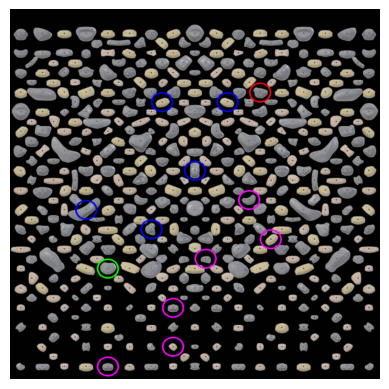

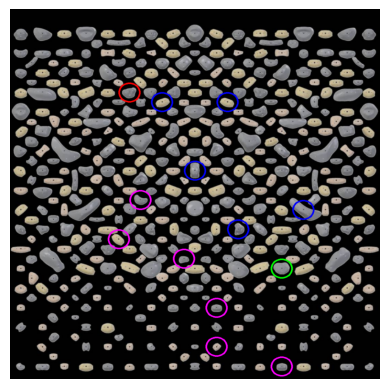

In [9]:
frame = "p318r8p333r6p451r6p477r8p552r6p567r8p584r6p611r8p613r5p631r6p682r8p714r8p725r7"
draw_problem(frame)
draw_problem(get_mirror(frame))

### Now we can create a mirror of our data

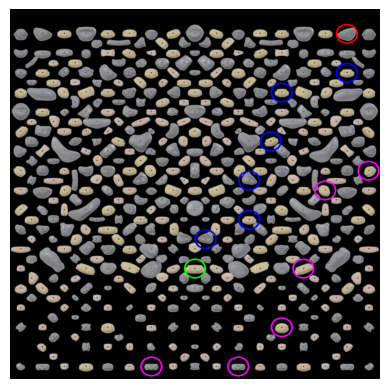

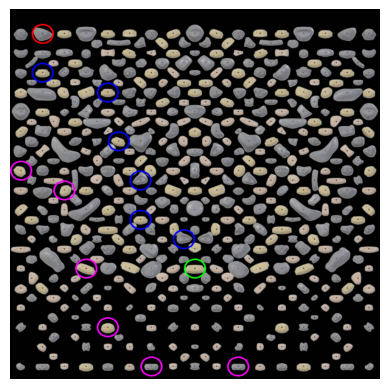

In [10]:
mirror_df = df.copy()
mirror_df['Frames'] = mirror_df['Frames'].apply(get_mirror)
draw_problem(df['Frames'][0])
draw_problem(mirror_df['Frames'][0])

### Now we finally have our final dataset.

In [11]:
final_df = pd.concat([df, mirror_df], ignore_index = True)
final_df['Feet'] = final_df['Frames'].apply(count_feet)
final_df['Hands'] = final_df['Frames'].apply(count_hands)
print(final_df.shape)
print(final_df["Frames"][0])
print(final_df.head())

(2810, 9)
p305r5p462r6p480r6p484r8p490r6p498r8p515r8p532r6p543r8p579r8p683r6p701r8p715r6p786r7
            Setter         Name  Description  Matching  Angle  \
0  tensionclimbing      Tremolo  No matching         0   40.0   
1  tensionclimbing      Tremolo  No matching         0   45.0   
2  tensionclimbing    Moondance  No matching         0   35.0   
3  tensionclimbing   Wholeberry  No matching         0   35.0   
4  tensionclimbing  Wayward Son  No Matching         0   35.0   

                                              Frames  Difficulty  Feet  Hands  
0  p305r5p462r6p480r6p484r8p490r6p498r8p515r8p532...        14.0     6      8  
1  p305r5p462r6p480r6p484r8p490r6p498r8p515r8p532...        16.0     6      8  
2  p306r8p470r8p476r8p485r8p692r6p697r5p722r5p725...        12.0     5      5  
3  p439r5p447r8p476r8p478r8p480r6p484r8p485r8p500...        13.0     6     10  
4  p306r8p470r8p476r8p485r8p692r6p697r5p722r5p725...        14.0     6      7  


# Encoding our Data

For the purpose of training our model I am going to use a neural network using an encoding that will use one hot for hold type, with an additional 4 encodings for hold_angle, matching, h and w. Hold_angle, Height and Width will all be normalized.

## Normalizing Our Data

In [12]:
values = np.array(list(coords_map.values()))
min_val = np.min(values, axis=0)
max_val = np.max(values, axis= 0)
range_val = max_val - min_val
range_val[range_val == 0] = 1
normalized_coords = {k : (v - min_val) / range_val for k, v in coords_map.items()}

scaler = MinMaxScaler()

final_df['Angle'] = scaler.fit_transform(final_df[['Angle']])


## Encode our data

In [ ]:
def encode_frame(frame : str, matching, angle):
    p, r  = split_frame(frame)
    encoded = np.zeros((8, 498))
    s = {0, 1}
    for i in range(len(p)):
        hold = p[i]
        idx = encode_map[hold]
        r_idx = r[i] - 5
        if not 0 <= r_idx < 4:
            print(r_idx)
        encoded[r_idx, idx] = np.round(1.0, 2)
        # Encode Height and Width
        encoded[4, idx] = normalized_coords[hold][0]
        encoded[5, idx] = normalized_coords[hold][1]
        # Encode Matching and Angle
        encoded[6, idx] = matching
        encoded[7, idx] = angle
    return encoded

X = []
y = []
names = []
global_features = []


for _, row in final_df.iterrows():
    frame = row['Frames']
    matching = row['Matching']
    angle = row['Angle']
    feet = row['Feet']
    hands = row['Hands']
    encoded = encode_frame(frame, matching, angle)
    X.append(encoded)
    names.append(row['Name'])
    y.append(row['Difficulty'])
    global_features.append([matching, angle, feet, hands])

X = np.array(X)
y = np.array(y)
names = np.array(names)
global_features = np.array(global_features)

## Export our data

In [14]:
np.savez("climbing_dataset.npz", X=X, y=y, names=names, global_features = global_features)